In [2]:
## Image augmentation
#!pip install imgaug

## ONLY used for dice metric and IOU metric computation, models are made from scratch
#!pip install -U segmentation-models

## Required to save models in HDF5 format
#!pip install pyyaml h5py

## Install nibabel
#!pip install nibabel

## Install scikit-learn library
#!pip install sklearn

## Install tensorflow and keras
#!pip uninstall tensorflow==2.2.0
#!pip install keras
#!pip install keras-segmentation

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn
import cv2 as cv
import nibabel as nib
import pickle
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm
import gc
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Multiply
from sklearn.model_selection import train_test_split
import keras_segmentation as ks

warnings.filterwarnings('ignore')
%matplotlib inline
print("Version: ", tf.version.VERSION)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "not available")

Version:  2.4.1
GPU is available


## 1. Load metada

In [2]:
metadata = pd.read_csv(r"G:\lung_dataset\metadata.csv")
# metadata.replace('../input/covid19-ct-scans/', '', regex=True, inplace=True)
print(metadata.shape)
metadata.head()

(20, 4)


ct_scan  \
0  G:/lung_dataset/ct_scans/coronacases_org_001.nii   
1  G:/lung_dataset/ct_scans/coronacases_org_002.nii   
2  G:/lung_dataset/ct_scans/coronacases_org_003.nii   
3  G:/lung_dataset/ct_scans/coronacases_org_004.nii   
4  G:/lung_dataset/ct_scans/coronacases_org_005.nii   

                                       lung_mask  \
0  G:/lung_dataset/lung_mask/coronacases_001.nii   
1  G:/lung_dataset/lung_mask/coronacases_002.nii   
2  G:/lung_dataset/lung_mask/coronacases_003.nii   
3  G:/lung_dataset/lung_mask/coronacases_004.nii   
4  G:/lung_dataset/lung_mask/coronacases_005.nii   

                                      infection_mask  \
0  G:/lung_dataset/infection_mask/coronacases_001...   
1  G:/lung_dataset/infection_mask/coronacases_002...   
2  G:/lung_dataset/infection_mask/coronacases_003...   
3  G:/lung_dataset/infection_mask/coronacases_004...   
4  G:/lung_dataset/infection_mask/coronacases_005...   

                             lung_and_infection_mask  
0  G:/lung_dataset/lung_and_infection_mask/corona...  
1  G:/lung_dataset/lung_and_infection_mask/corona...  
2  G:/lung_dataset/lung_and_infection_mask/corona...  
3  G:/lung_dataset/lung_and_infection_mask/corona...  
4  G:/lung_dataset/lung_and_infection_mask/corona...

In [3]:
# img_size is the preferred image size to which the image is to be resized
img_size = 512

In [4]:
clahe = cv.createCLAHE(clipLimit=3.0) # used to improve contrast in images

def clahe_enhancer(img, clahe, axes):
    '''Contract Limited Adaptive Histogram Equalizer'''
    img = np.uint8(img*255)  
    clahe_img = clahe.apply(img)

    if len(axes) > 0 :    
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])

        axes[1].imshow(clahe_img, cmap='bone')
        axes[1].set_title("CLAHE Enhanced CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])

        if len(axes) > 2 :
            axes[2].hist(img.flatten(), alpha=0.4, label='Original CT scan')
            axes[2].hist(clahe_img.flatten(), alpha=0.4, label="CLAHE Enhanced CT scan")
            plt.legend()
        
    return(clahe_img)

In [5]:
def get_contours(img):
    img = np.uint8(img*255)
    
    kernel = np.ones((3,3),np.float32)/9 # create a 3x3 array filled with 1s
    img = cv.filter2D(img, -1, kernel) # doing a convolution between a kernel and an image
    
    ret, thresh = cv.threshold(img, 50, 255, cv.THRESH_BINARY) # If pixel value is greater than a threshold value, it is assigned one value (may be white), else it is assigned another value (may be black)
    contours, hierarchy = cv.findContours(thresh, 2, 1)
    #Areas = [cv.contourArea(cc) for cc in contours]; print(Areas)
    
    # filter contours that are too large or small
    size = get_size(img)
    contours = [cc for cc in contours if contourOK(cc, size)]
    return contours

def get_size(img):
    ih, iw = img.shape
    return iw * ih

def contourOK(cc, size):
    x, y, w, h = cv.boundingRect(cc)
    if ((w < 50 and h > 150) or (w > 150 and h < 50)) : 
        return False # too narrow or wide is bad
    area = cv.contourArea(cc)
    return area < (size * 0.5) and area > 200

def find_boundaries(img, contours):
    # margin is the minimum distance from the edges of the image, as a fraction
    ih, iw = img.shape
    minx = iw
    miny = ih
    maxx = 0
    maxy = 0

    for cc in contours:
        x, y, w, h = cv.boundingRect(cc)
        if x < minx: minx = x
        if y < miny: miny = y
        if x + w > maxx: maxx = x + w
        if y + h > maxy: maxy = y + h

    return (minx, miny, maxx, maxy)

def crop_(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:maxy, minx:maxx]
    
def crop_img(img, axes) :
    contours = get_contours(img)
    #plt.figure() # uncomment to troubleshoot
    #canvas = np.zeros_like(img)
    #cv.drawContours(canvas , contours, -1, (255, 255, 0), 1)
    #plt.imshow(canvas)
    bounds = find_boundaries(img, contours)
    cropped_img = crop_(img, bounds)

    if len(axes) > 0 :
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])
        
        axes[1].imshow(cropped_img, cmap='bone')
        axes[1].set_title("Cropped CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])
        
    return cropped_img, bounds

## Load all the data

In [6]:
cts_all = []
lungs_all = []
infects_all = []
max_w, max_h = 0, 0 #max width and height

for fnum in tqdm.tqdm(range(20)) : #range(metadata.shape[0])) :
    cts = nib.load(metadata.loc[fnum, 'ct_scan'])
    lungs = nib.load(metadata.loc[fnum, 'lung_mask'])
    infec = nib.load(metadata.loc[fnum, 'infection_mask'])
    
    slices = cts.shape[2]

    arr_cts = cts.get_fdata()
    arr_lungs = lungs.get_fdata()
    arr_infec = infec.get_fdata()

    arr_cts = np.rot90(np.array(arr_cts))
    arr_lungs = np.rot90(np.array(arr_lungs))
    arr_infec = np.rot90(np.array(arr_infec))

    # arr_cts = arr_cts[:, :, round(slices*0.2):round(slices*0.8)]
    # arr_lungs = arr_lungs[:, :, round(slices*0.2):round(slices*0.8)]
    # arr_infec = arr_infec[:, :, round(slices*0.2):round(slices*0.8)]

    arr_cts = np.reshape(np.rollaxis(arr_cts, 2), 
                     (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
    arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2), 
                     (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
    arr_infec = np.reshape(np.rollaxis(arr_infec, 2), 
                     (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1))
    
    for ii in range(arr_cts.shape[0]):
        img_lungs = cv.resize(arr_lungs[ii], dsize=(img_size, img_size), 
                              interpolation=cv.INTER_AREA)
        # xmax, xmin = img_lungs.max(), img_lungs.min()
        # img_lungs = (img_lungs - xmin)/(xmax - xmin)
        cropped_lungs, bounds = crop_img(img_lungs, [])
        lungs_all.append(img_lungs)
        
        h, w = cropped_lungs.shape
        max_h, max_w = max(max_h, h), max(max_w, w)

        img_ct = cv.resize(arr_cts[ii], dsize=(img_size, img_size), 
                           interpolation=cv.INTER_AREA)
        xmax, xmin = img_ct.max(), img_ct.min()
        img_ct = (img_ct - xmin)/(xmax - xmin)
        clahe_ct = clahe_enhancer(img_ct, clahe, [])
        cropped_ct = crop_(clahe_ct, bounds)
        cts_all.append(clahe_ct)

        img_infec = cv.resize(arr_infec[ii], dsize=(img_size, img_size), 
                              interpolation=cv.INTER_AREA)
        cropped_infec = crop_(img_infec, bounds)
        infects_all.append(img_infec)

100%|██████████| 20/20 [01:38<00:00,  4.95s/it]


In [7]:
print(len(cts_all))

3520


## Resize and reshape

In [8]:
num_pix = 100
del_lst = []
for ii in tqdm.tqdm(range(len(cts_all))) :
    try :
        cts_all[ii] = cv.resize(cts_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        cts_all[ii] = np.reshape(cts_all[ii], (num_pix, num_pix, 1))

        lungs_all[ii] = cv.resize(lungs_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        lungs_all[ii] = np.reshape(lungs_all[ii], (num_pix, num_pix, 1))

        infects_all[ii] = cv.resize(infects_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        infects_all[ii] = np.reshape(infects_all[ii], (num_pix, num_pix, 1))
    except :
        del_lst.append(ii)
        
for idx in del_lst[::-1] :
    del cts_all[idx]
    del lungs_all[idx]
    del infects_all[idx]

100%|██████████| 3520/3520 [00:12<00:00, 283.33it/s]


* See the following fully processed sample

Text(0.5, 1.0, 'Infection')

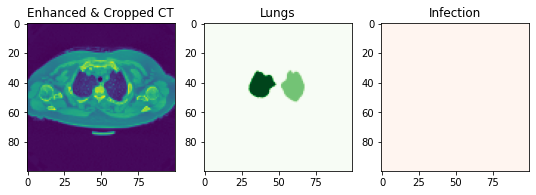

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(9,3))

show_num = 250

axes[0].imshow(cts_all[show_num][:, :, 0])
axes[0].set_title("Enhanced & Cropped CT")

axes[1].imshow(lungs_all[show_num][:, :, 0], cmap='Greens')
axes[1].set_title("Lungs")

axes[2].imshow(infects_all[show_num][:, :, 0], cmap='Reds')
axes[2].set_title("Infection")

## Dump the preprocessed data

In [12]:
with open('preprocessed_cts_na_c.cp', 'wb') as myfile:
    pickle.dump({'cts_all': cts_all, 'lungs_all': lungs_all, 'infects_all': infects_all}, myfile)

In [13]:
infect_bool = np.ones((1, len(infects_all)))
for ii in range(len(infects_all)):
    if np.unique(infects_all[ii]).size == 1:
        infect_bool[0, ii] = 0
        
print("Number of CTs with no infection: %d" %(len(infects_all)-infect_bool.sum()))

#for index in sorted(no_masks, reverse = True):  
#    del infections[index]  
#    del cts[index]

Number of CTs with no infection: 498


* Notice how the infection can be distinguised clearly after enhancement.

* Saving the numpy arrays to later reuse the same preprocessing for other models rather than doing it again.

## Data augmentation pipeline

In [14]:
ia.seed(1)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Flipud(0.5), # vertical flips
    
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-15, 15),
        shear=(-15, 15)
    )
], random_order=True) # apply augmenters in random order

In [15]:
num_augs = round(len(cts_all)/2.)
rand_idx = np.random.randint(0, len(cts_all), size=num_augs)

sample_cts = [cts_all[ii] for ii in rand_idx]
sample_lungs = [lungs_all[ii] for ii in rand_idx]
sample_infects = [infects_all[ii] for ii in rand_idx]

In [16]:
seq_det = seq.to_deterministic()
cts_aug = seq_det.augment_images(sample_cts)
lungs_aug = seq_det.augment_images(sample_lungs)
infects_aug = seq_det.augment_images(sample_infects)

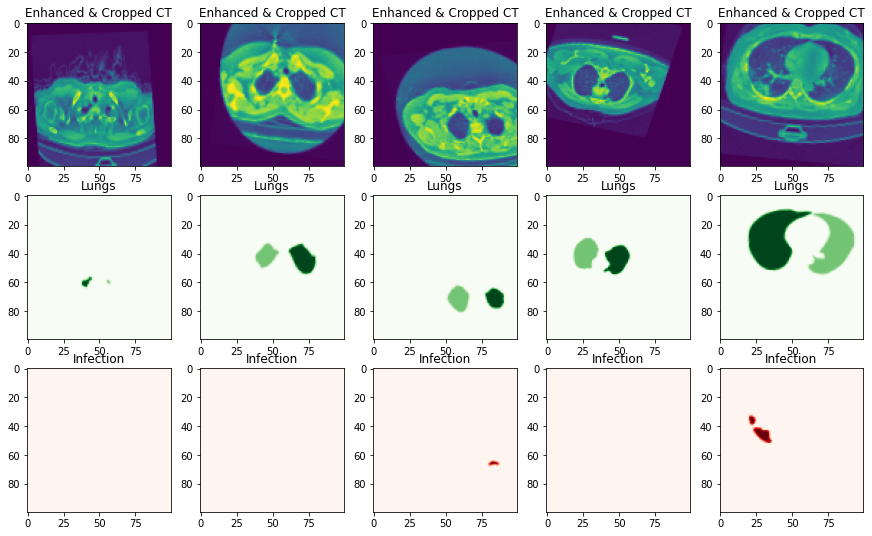

In [17]:
fig, axes = plt.subplots(3, 5, figsize=(15,9))

for ii in range(5) :
    axes[0, ii].imshow(cts_aug[ii*10+50][:, :, 0])
    axes[0, ii].set_title("Enhanced & Cropped CT")

    axes[1, ii].imshow(lungs_aug[ii*10+50][:, :, 0], cmap='Greens')
    axes[1, ii].set_title("Lungs")

    axes[2, ii].imshow(infects_aug[ii*10+50][:, :, 0], cmap='Reds')
    axes[2, ii].set_title("Infection");

## Pool augmented data and convert it

In [18]:
cts_all = tf.convert_to_tensor(cts_all)
cts_aug = tf.convert_to_tensor(cts_aug)
lungs_all = tf.convert_to_tensor(lungs_all)
lungs_aug = tf.convert_to_tensor(lungs_aug)
infects_all = tf.convert_to_tensor(infects_all)
infects_aug = tf.convert_to_tensor(infects_aug)

cts = tf.concat([cts_all, cts_aug], axis=0)
lungs = tf.concat([lungs_all, lungs_aug], axis=0)
infects = tf.concat([infects_all, infects_aug], axis=0)

In [19]:
indices = tf.range(start=0, limit=cts.shape[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)
                       
cts = tf.gather(cts, shuffled_indices)
lungs = tf.gather(lungs, shuffled_indices)
infects = tf.gather(infects, shuffled_indices)

print(cts.shape, lungs.shape, infects.shape)

(5280, 100, 100, 1) (5280, 100, 100, 1) (5280, 100, 100, 1)


## Save augmented data

In [20]:
with open('augmented_cts_a_nc.cp', 'wb') as myfile:
    pickle.dump({'cts': cts, 'lungs': lungs, 'infects': infects}, myfile)

* Just overlaying infection masks over the corresponding CT scans

In [20]:
def plot_cts_infects(ct, infect, axes) :

    axes[0].imshow(ct[:,:,0], cmap='bone')
    axes[0].set_title('CT image')

    axes[1].imshow(ct[:,:,0], cmap='bone')
    axes[1].imshow(infect[:,:,0], alpha=0.5, cmap='nipy_spectral')
    axes[1].set_title('Infection')

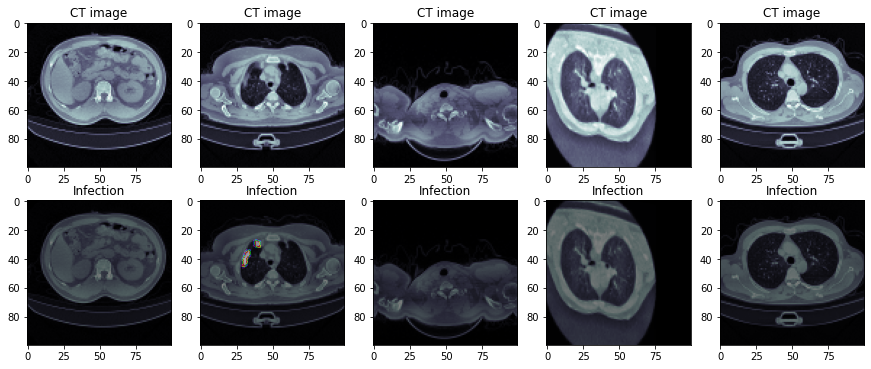

In [21]:
fig, axes = plt.subplots(2, 5, figsize=(15,6))

for ii, idx in enumerate(range(150, 350, 40)) :
    plot_cts_infects(cts[idx], infects[idx], list(axes[:,ii]))

In [22]:
## see https://github.com/keras-team/keras/issues/9395

def dice_coeff(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred): #Binary Cross-Entropy
    loss = 0.5*losses.binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    # print(f"\n\ny_true: {y_true}\ny_pred: {y_pred}\nbc: {losses.binary_crossentropy(y_true, y_pred)}\ndl: {dice_loss(y_true, y_pred)}\nhalf_bc: {0.5*losses.binary_crossentropy(y_true, y_pred)}\nhalf dl: {dice_loss(y_true, y_pred)*0.5}\nloss: {loss}")
    return loss

def tversky_loss(y_true, y_pred):
    alpha, beta  = 0.5, 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred
    p1 = ones-y_pred
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) 
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + 
                     K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1*m2)
    score = (2.*K.sum(w*intersection) + smooth) / (K.sum(w*m1) + K.sum(w*m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    averaged_mask = K.pool2d(y_true, pool_size=(50, 50), strides=(1, 1), 
                             padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5.*K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 0.5*weighted_bce_loss(y_true, y_pred, weight) + 0.5*dice_loss(y_true, y_pred)
    return loss

## Cosine Annealing Learning Rate

An effective snapshot ensemble requires training a neural network with an aggressive learning rate schedule.

The cosine annealing schedule is an example of an aggressive learning rate schedule where learning rate starts high and is dropped relatively rapidly to a minimum value near zero before being increased again to the maximum.

We can implement the schedule as described in the 2017 paper “Snapshot Ensembles: Train 1, get M for free.” The equation requires the total training epochs, maximum learning rate, and number of cycles as arguments as well as the current epoch number. The function then returns the learning rate for the given epoch.

See https://machinelearningmastery.com/snapshot-ensemble-deep-learning-neural-network/

In [23]:
# define custom learning rate schedule
class CosineAnnealingLearningRateSchedule(callbacks.Callback):
    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()
 
    # calculate learning rate for an epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = np.floor(n_epochs/n_cycles)
        cos_inner = (np.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (np.cos(cos_inner) + 1)
 
    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs=None):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        # set learning rate
        K.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)

In [24]:
# define learning rate callback
n_epochs = 200
# n_epochs = 10
lrmax = 0.002
n_cycles = n_epochs / 25
lr_cb = CosineAnnealingLearningRateSchedule(n_epochs, n_cycles, lrmax)

* All the hyperparameters are put in place after repeating trial and error for a fixed number of epochs.

## Model building blocks

In [25]:
def cts_block_1 (x_in, conv2Dfilters, maxpool2Dsize=(2,2)) :
    x = Conv2D(conv2Dfilters, (3,3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x)
    x_inter = BatchNormalization() (x)
    x = MaxPooling2D(maxpool2Dsize) (x_inter) 
    x = Dropout(0.25)(x) 
    
    return x, x_inter

def cts_block_2 (x_in, conv2Dfilters) :
    x = BatchNormalization() (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x) 
    
    return x

## keras model with one input (CTs) and two segmented output (lungs & infections)

In [26]:
def cts_model (input_shape) :
    
    x_input = Input(input_shape)
    
    ##################################  LUNG SEGMENTATION  ######################
    x, x1 = cts_block_1 (x_input, 32, maxpool2Dsize=(2,2)) #x: 50x50
    x, x2 = cts_block_1 (x, 64, maxpool2Dsize=(2,2)) #x: 25x25
    x, _ = cts_block_1 (x, 128, maxpool2Dsize=(1,1)) #x: 25x25
    x, _ = cts_block_1 (x, 256, maxpool2Dsize=(1,1)) #x: 25x25

    x = cts_block_2 (x, 256) #x: 25x25
    
    x = Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same') (x) #x: 50x50
    x = cts_block_2 (x, 128) #x: 50x50

    x = Conv2DTranspose(64, (2, 2), padding='same') (x) #x: 50x50
    x = concatenate([x, x2]) #x: 50x50
    x = cts_block_2 (x, 64) #x: 50x50

    x = Conv2DTranspose(32, (2, 2), strides=(2,2), padding='same') (x) #x: 100x100
    x = concatenate([x, x1], axis=3) #x: 100x100
    x = cts_block_2 (x, 32) #x: 100x100

    lung_seg = Conv2D(1, (1, 1), activation='sigmoid', name='lung_output') (x) #x: 100x100

    ##################################  INFECTION SEGMENTATION  ######################
    x, x1 = cts_block_1 (lung_seg, 32, maxpool2Dsize=(2,2)) #x: 50x50
    x, x2 = cts_block_1 (x, 64, maxpool2Dsize=(2,2)) #x: 25x25
    x, _ = cts_block_1 (x, 128, maxpool2Dsize=(1,1)) #x: 25x25
    x, _ = cts_block_1 (x, 256, maxpool2Dsize=(1,1)) #x: 25x25
    
    x = cts_block_2 (x, 256) #x: 25x25
    
    x = Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same') (x) #x: 50x50
    x = cts_block_2 (x, 128) #x: 50x50

    x = Conv2DTranspose(64, (2, 2), padding='same') (x) #x: 50x50
    x = concatenate([x, x2]) #x: 50x50
    x = cts_block_2 (x, 64) #x: 50x50

    x = Conv2DTranspose(32, (2, 2), strides=(2,2), padding='same') (x) #x: 100x100
    x = concatenate([x, x1], axis=3) #x: 100x100
    x = cts_block_2 (x, 32) #x: 100x100

    infect_seg = Conv2D(1, (1, 1), activation='sigmoid', name='infect_output') (x) # identifying infections

    model = Model(inputs=x_input, outputs=[lung_seg, infect_seg], name='cts_model')
    
    return model

In [27]:
ctsModel = cts_model(cts.shape[1:])
ctsModel.summary()

Model: "cts_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 100, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 100, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________

## Split data into train and validation sets

In [28]:
train_size = int(0.8*cts.shape[0])
test_size = int(0.1*cts.shape[0])

X_train, yl_train, yi_train = (cts[:train_size]/255, 
                               lungs[:train_size], 
                               infects[:train_size])

X_valid, yl_valid, yi_valid = (cts[train_size:train_size+test_size]/255, 
                               lungs[train_size:train_size+test_size],
                               infects[train_size:train_size+test_size])

X_test, yl_test, yi_test = (cts[train_size+test_size:]/255, 
                            lungs[train_size+test_size:],
                            infects[train_size+test_size:])

print(X_train.shape, yl_train.shape, yi_train.shape)
print(X_test.shape, yl_test.shape, yi_test.shape)

(4224, 100, 100, 1) (4224, 100, 100, 1) (4224, 100, 100, 1)
(528, 100, 100, 1) (528, 100, 100, 1) (528, 100, 100, 1)


## Callback (model checkpointing with the highest validation dice coefficient)

In [29]:
batch_size = 64
epochs = n_epochs

checkpoint_fpath = "ctsmodel-lungs-infect-seg.hdf5"
cts_checkpoint_cb = callbacks.ModelCheckpoint(checkpoint_fpath, 
                                              monitor='val_infect_output_dice_coeff', 
                                              save_best_only=True, 
                                              mode='max', 
                                              verbose=1,
                                              save_weights_only=True)

## Training

In [30]:
optim = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.99)

loss_dict = {'lung_output': weighted_bce_dice_loss, 'infect_output': weighted_bce_dice_loss}
loss_weight_dict = {'lung_output': 1.0, 'infect_output': 1.0}

ctsModel.compile(optimizer=optim, loss=loss_dict, loss_weights=loss_weight_dict, metrics=[dice_coeff])

ctsRes = ctsModel.fit(x=X_train, 
                      y={'lung_output': yl_train, 'infect_output': yi_train}, 
                      batch_size=batch_size, 
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_valid, 
                                       {'lung_output': yl_valid, 'infect_output': yi_valid}),
                      callbacks = [cts_checkpoint_cb, lr_cb])


h 157/200
66/66 [==============================] - 51s 774ms/step - loss: -0.7280 - lung_output_loss: -0.8367 - infect_output_loss: 0.1087 - lung_output_dice_coeff: 1.1114 - infect_output_dice_coeff: 0.8069 - val_loss: -0.6872 - val_lung_output_loss: -0.8038 - val_infect_output_loss: 0.1166 - val_lung_output_dice_coeff: 1.1067 - val_infect_output_dice_coeff: 0.7916

Epoch 00157: val_infect_output_dice_coeff did not improve from 0.81022
Epoch 158/200
66/66 [==============================] - 50s 760ms/step - loss: -0.7245 - lung_output_loss: -0.8303 - infect_output_loss: 0.1058 - lung_output_dice_coeff: 1.1078 - infect_output_dice_coeff: 0.8133 - val_loss: -0.6952 - val_lung_output_loss: -0.8031 - val_infect_output_loss: 0.1079 - val_lung_output_dice_coeff: 1.1042 - val_infect_output_dice_coeff: 0.8067

Epoch 00158: val_infect_output_dice_coeff did not improve from 0.81022
Epoch 159/200
66/66 [==============================] - 48s 729ms/step - loss: -0.7338 - lung_output_loss: -0.8413 - 

In [31]:
ctsModel_json = ctsModel.to_json()
with open('ctsModel-lungs-infects.json', 'w') as myfile:
     myfile.write(ctsModel_json)

In [33]:
ctsModel.save("trained_models/26-03_200e_nc_a.h5")

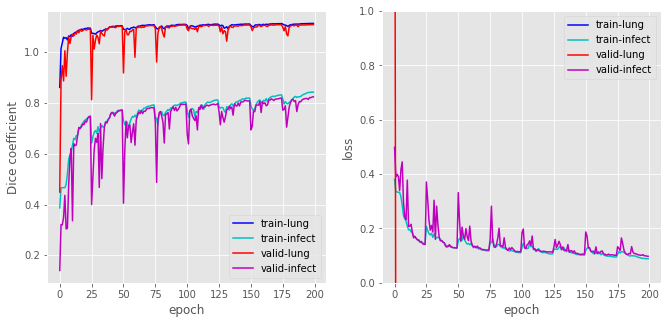

In [34]:
plt.style.use('ggplot')

fig, axes = plt.subplots(1, 2, figsize=(11,5))

axes[0].plot(ctsRes.history['lung_output_dice_coeff'], color='b', label='train-lung')
axes[0].plot(ctsRes.history['infect_output_dice_coeff'], color='c', label='train-infect')
axes[0].plot(ctsRes.history['val_lung_output_dice_coeff'], color='r', label='valid-lung')
axes[0].plot(ctsRes.history['val_infect_output_dice_coeff'], color='m', label='valid-infect')
axes[0].set_ylabel('Dice coefficient')
axes[0].set_xlabel('epoch')
axes[0].legend()
# axes[0].set_ylim([0.5, 0.85])

axes[1].plot(ctsRes.history['lung_output_loss'], color='b', label='train-lung')
axes[1].plot(ctsRes.history['infect_output_loss'], color='c', label='train-infect')
axes[1].plot(ctsRes.history['val_lung_output_loss'], color='r', label='valid-lung')
axes[1].plot(ctsRes.history['val_infect_output_loss'], color='m', label='valid-infect')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylim([0,1])
axes[1].legend()

In [34]:
test_result = ctsModel.evaluate(x=X_test, 
                                y={'lung_output': yl_test, 'infect_output': yi_test},
                                batch_size=batch_size)

print('Test data:\n\t Lung: %.4f loss, %.4f dice coeff\n\t Infection: %.4f loss, %.4f dice coeff' 
      %(test_result[1], test_result[3], test_result[2], test_result[4]))

5/5 [==============================] - 3s 649ms/step - loss: nan - lung_output_loss: nan - infect_output_loss: 0.4997 - lung_output_dice_coeff: nan - infect_output_dice_coeff: 0.0758
Test data:
	 Lung: nan loss, nan dice coeff
	 Infection: 0.4997 loss, 0.0758 dice coeff


In [35]:
 gc.collect()

25441

### Run this if you want to train the network more

In [36]:
checkpoint_fpath = "ctsmodel-lungs-infect-seg-2.hdf5"
cts_checkpoint_cb = callbacks.ModelCheckpoint(checkpoint_fpath, 
                                              monitor='val_infect_output_dice_coeff', 
                                              save_best_only=True, 
                                              mode='max', 
                                              verbose=1,
                                              save_weights_only=True)


ctsModel = cts_model(cts.shape[1:])

optim = optimizers.Adam(lr=5e-4, beta_1=0.9, beta_2=0.99)

ctsModel.compile(optimizer=optim, loss=loss_dict, loss_weights=loss_weight_dict, metrics=[dice_coeff])

ctsModel.load_weights('ctsmodel-lungs-infect-seg.hdf5')

ctsRes = ctsModel.fit(x=X_train, 
                      y={'lung_output': yl_train, 'infect_output': yi_train},
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_data=(X_valid, 
                                       {'lung_output': yl_valid, 
                                        'infect_output': yi_valid}),
                      callbacks = [cts_checkpoint_cb])

_output_loss: 0.4997 - val_lung_output_dice_coeff: nan - val_infect_output_dice_coeff: 0.0730

Epoch 00153: val_infect_output_dice_coeff did not improve from 0.26524
Epoch 154/200
40/40 [==============================] - 24s 595ms/step - loss: nan - lung_output_loss: nan - infect_output_loss: 0.5022 - lung_output_dice_coeff: nan - infect_output_dice_coeff: 0.0727 - val_loss: nan - val_lung_output_loss: nan - val_infect_output_loss: 0.4999 - val_lung_output_dice_coeff: nan - val_infect_output_dice_coeff: 0.0725

Epoch 00154: val_infect_output_dice_coeff did not improve from 0.26524
Epoch 155/200
40/40 [==============================] - 24s 595ms/step - loss: nan - lung_output_loss: nan - infect_output_loss: 0.5023 - lung_output_dice_coeff: nan - infect_output_dice_coeff: 0.0710 - val_loss: nan - val_lung_output_loss: nan - val_infect_output_loss: 0.4998 - val_lung_output_dice_coeff: nan - val_infect_output_dice_coeff: 0.0731

Epoch 00155: val_infect_output_dice_coeff did not improve fro

In [37]:
ctsModel.save("trained_models/25-03_400e_nc_a.h5")

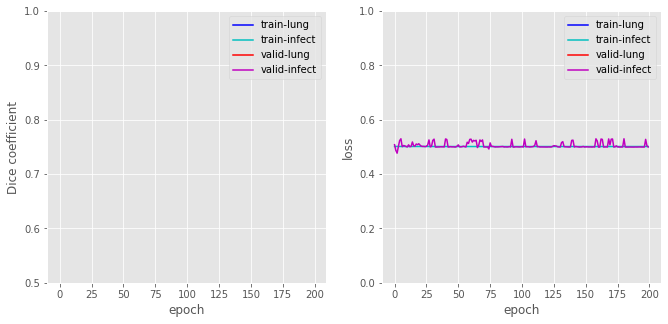

In [38]:
plt.style.use('ggplot')

fig, axes = plt.subplots(1, 2, figsize=(11,5))

axes[0].plot(ctsRes.history['lung_output_dice_coeff'], color='b', label='train-lung')
axes[0].plot(ctsRes.history['infect_output_dice_coeff'], color='c', label='train-infect')
axes[0].plot(ctsRes.history['val_lung_output_dice_coeff'], color='r', label='valid-lung')
axes[0].plot(ctsRes.history['val_infect_output_dice_coeff'], color='m', label='valid-infect')
axes[0].set_ylabel('Dice coefficient')
axes[0].set_xlabel('epoch')
axes[0].legend()
axes[0].set_ylim([0.5, 1])

axes[1].plot(ctsRes.history['lung_output_loss'], color='b', label='train-lung')
axes[1].plot(ctsRes.history['infect_output_loss'], color='c', label='train-infect')
axes[1].plot(ctsRes.history['val_lung_output_loss'], color='r', label='valid-lung')
axes[1].plot(ctsRes.history['val_infect_output_loss'], color='m', label='valid-infect')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylim([0,1])
axes[1].legend();

In [39]:
%matplotlib inline
from matplotlib import pyplot as plt

In [40]:
test_result = ctsModel.evaluate(x=X_test, 
                                y={'lung_output': yl_test, 'infect_output': yi_test},
                                batch_size=batch_size)

print('Test data:\n\t Lung: %.4f loss, %.4f dice coeff\n\t Infection: %.4f loss, %.4f dice coeff' 
      %(test_result[1], test_result[3], test_result[2], test_result[4]))

5/5 [==============================] - 1s 196ms/step - loss: nan - lung_output_loss: nan - infect_output_loss: 0.4999 - lung_output_dice_coeff: nan - infect_output_dice_coeff: 0.0737
Test data:
	 Lung: nan loss, nan dice coeff
	 Infection: 0.4999 loss, 0.0737 dice coeff


In [41]:
# model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[sm.metrics.IOUScore(threshold=0.55)])

In [32]:
yl_pred, yi_pred = ctsModel.predict(X_test)
print(yl_pred.shape, yi_pred.shape)

(318, 100, 100, 1) (318, 100, 100, 1)


## Evaluate network performance

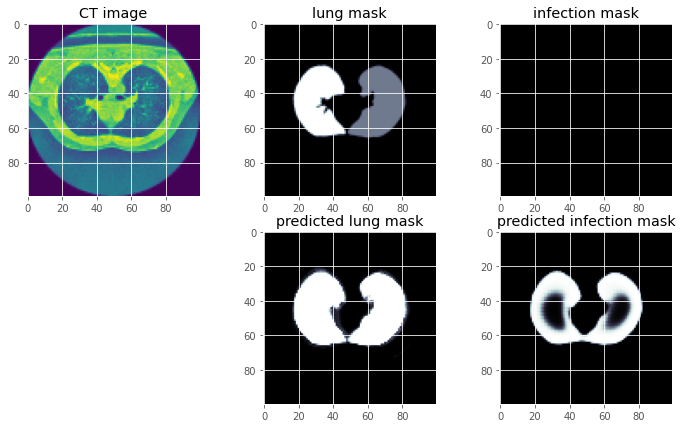

In [33]:
def compare_actual_and_predicted(img_num):

    fig = plt.figure(figsize=(12,7))

    plt.subplot(2,3,1)
    plt.imshow(tf.reshape(X_test[img_num], [num_pix, num_pix]))
    plt.title('CT image')

    plt.subplot(2,3,2)
    plt.imshow(tf.reshape(yl_test[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('lung mask')

    plt.subplot(2,3,3)
    plt.imshow(tf.reshape(yi_test[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('infection mask')

    plt.subplot(2,3,5)
    plt.imshow(tf.reshape(yl_pred[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('predicted lung mask')

    plt.subplot(2,3,6)
    plt.imshow(tf.reshape(yi_pred[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('predicted infection mask')
    

compare_actual_and_predicted(43)